In [1]:
import os
import pandas as pd

path = "data"

def createPath(dir):
  return os.path.join(path, dir)

def map_inputs(input):
  for key in input.keys():
    if key != "index":
      return input[key]

In [2]:
## Prepare data

raw_data_sample_path = os.path.join(path, 'raw_data_sample.json')
sample_data = pd.read_json(raw_data_sample_path)

sample_data['question'] = sample_data['inputs'].map(lambda input: map_inputs(input))

unique_answers_per_category = {}
classifying_tasks = []

# find unique answers for each category
for category in sample_data['task'].unique():
  category_data = sample_data[sample_data['task'] == category]
  unique_answers_per_category[category] = category_data['answer'].unique()

for category, answers in unique_answers_per_category.items():
  if len(answers)<10:
    classifying_tasks.append(category)

print(f"Number of classification tasks: {len(classifying_tasks)}")
sample_data = sample_data[sample_data['task'].isin(classifying_tasks)]

Number of classification tasks: 155


In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Fit the encoder to the data
le.fit(sample_data["answer"])

le.classes_
# Transform the data
sample_data["label"] = le.transform(sample_data["answer"])

In [4]:
print(sample_data.shape)
sample_data.head(2)

(9465, 9)


,index,raw_dataset_id,answer,inputs,prompt_template,prompt,task,question,label
0,0,51,suggestive,"{'index': '51', 'text': 'The mark ""Equine Tech...",A mark is generic if it is the common name for...,A mark is generic if it is the common name for...,abercrombie,"The mark ""Equine Technologies"" for horse hoof ...",61
1,1,92,fanciful,"{'index': '92', 'text': 'The mark ""Lanbe"" for ...",A mark is generic if it is the common name for...,A mark is generic if it is the common name for...,abercrombie,"The mark ""Lanbe"" for custom wallets.",54


In [5]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the data
data = sample_data.copy()

# Separate the features and labels
X = data[['prompt', 'question']]
y = data['label']

# Convert the answers to label encoding
le = LabelEncoder()
y = le.fit_transform(y)

# Vectorize the prompt and question text
vectorizer = TfidfVectorizer()
X2e- = vectorizer.fit_transform(X['prompt'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Split: {X_train.shape, X_test.shape}")

# Train the gradient boosting classifier
model_1 = GradientBoostingClassifier()
model_1.fit(X_train, y_train)

# Make predictions on new data
new_y = model_1.predict(X_test)

# Convert the predictions back to original labels
new_y = le.inverse_transform(y_test)

print(f"Score on train", model_1.score(X_train, y_train))
print(f"Score on test data", model_1.score(X_test, y_test))

Score on train 0.886027469624934
Score on test data 0.7184363444268357


In [8]:
X_train.shape, X_test.shape

((7572, 20774), (1893, 20774))

In [17]:
## Lets verify the output
predictions = model_1.predict(X)

In [20]:
sample_data['predictions'] = le.inverse_transform(predictions)

In [25]:
correct_predictions = sum(sample_data['predictions'] == sample_data['answer'])
total_predictions = len(sample_data)
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 85.25%


### Lets plot confusion matrix for some of these categories

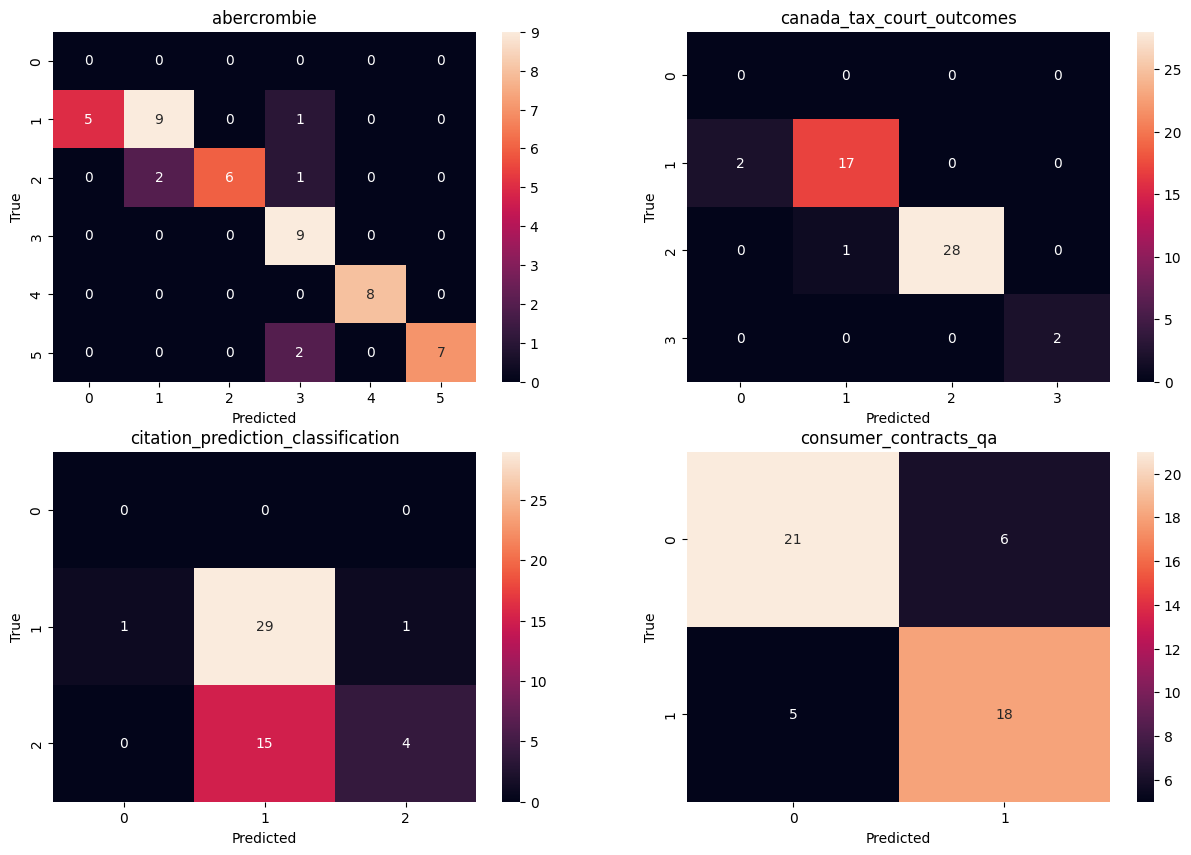

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot confusion matrix for each category
for i, category in enumerate(classifying_tasks[:4]):
    ax = axes[i // 2, i % 2]
    cm = confusion_matrix(sample_data[sample_data['task'] == category]['answer'],
                          sample_data[sample_data['task'] == category]['predictions'])
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, ax=ax, fmt='g')
    ax.set_title(category)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True');

plt.show();


In [42]:
# Which of these categories did the worst
category_accuracies = {}
for category in classifying_tasks:
  category_data = sample_data[sample_data['task'] == category]
  correct_predictions = sum(category_data['predictions'] == category_data['answer'])
  total_predictions = len(category_data)
  accuracy = correct_predictions / total_predictions
  category_accuracies[category] = accuracy

# Find the category with the lowest accuracy
lowest_accuracy_category = min(category_accuracies, key=category_accuracies.get)

print(f"Category with the lowest accuracy: {lowest_accuracy_category} with accuracy: {category_accuracies[lowest_accuracy_category]}")


Category with the lowest accuracy: cuad_rofr-rofo-rofn with accuracy: 0.56


### How did we do for each of these answer categories

In [40]:
category_accuracies

{'abercrombie': 0.78,
 'canada_tax_court_outcomes': 0.94,
 'citation_prediction_classification': 0.66,
 'consumer_contracts_qa': 0.78,
 'contract_nli_confidentiality_of_agreement': 0.8,
 'contract_nli_explicit_identification': 0.9,
 'contract_nli_inclusion_of_verbally_conveyed_information': 0.78,
 'contract_nli_limited_use': 0.94,
 'contract_nli_no_licensing': 0.82,
 'contract_nli_notice_on_compelled_disclosure': 0.92,
 'contract_nli_permissible_acquirement_of_similar_information': 0.88,
 'contract_nli_permissible_copy': 0.76,
 'contract_nli_permissible_development_of_similar_information': 0.98,
 'contract_nli_permissible_post-agreement_possession': 0.86,
 'contract_nli_return_of_confidential_information': 0.9,
 'contract_nli_sharing_with_employees': 0.92,
 'contract_nli_sharing_with_third-parties': 0.76,
 'contract_nli_survival_of_obligations': 0.9,
 'contract_qa': 0.96,
 'corporate_lobbying': 0.88,
 'cuad_affiliate_license-licensee': 0.76,
 'cuad_affiliate_license-licensor': 1.0,
 'c

### Analyse results for `consumer_contracts_qa`

Total data available for consumer_contracts_qa 50
Accuracy for consumer_contracts_qa: 0.78


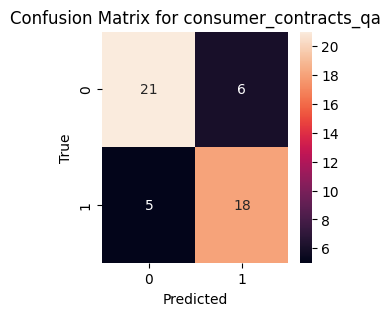

In [51]:
import matplotlib.pyplot as plt
# Get the data for the consumer_contracts_qa category
consumer_contracts_data = sample_data[sample_data['task'] == 'consumer_contracts_qa']

# Calculate the accuracy for the consumer_contracts_qa category
consumer_contracts_accuracy = category_accuracies['consumer_contracts_qa']

print(f"Total data available for consumer_contracts_qa: {len(consumer_contracts_data)}")
# Print the accuracy and the confusion matrix for the consumer_contracts_qa category
print(f"Accuracy for consumer_contracts_qa: {consumer_contracts_accuracy}")

# Get the confusion matrix for the consumer_contracts_qa category
consumer_contracts_cm = confusion_matrix(consumer_contracts_data['answer'], consumer_contracts_data['predictions'])

# Plot the confusion matrix for the consumer_contracts_qa category
plt.figure(figsize=(3, 3))
sns.heatmap(consumer_contracts_cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for consumer_contracts_qa')
plt.show();


### Some correct and incorrect predictions for `consumer_contracts_qa`

In [61]:
# Print some correct predictions for the consumer_contracts_qa category
correct_predictions = consumer_contracts_data[consumer_contracts_data['predictions'] == consumer_contracts_data['answer']]
print("Some correct predictions:")
print(correct_predictions[['prompt', 'task', 'answer', 'predictions']].head())
print("\n\n")

# Print some incorrect predictions for the consumer_contracts_qa category
incorrect_predictions = consumer_contracts_data[consumer_contracts_data['predictions'] != consumer_contracts_data['answer']]
print("Some incorrect predictions:")
print(incorrect_predictions[['prompt', 'task', 'answer', 'predictions']].head())


Some correct predictions:
                                                prompt                   task  \
200  3. Billing and Cancellation\n\n3.1. Billing Cy...  consumer_contracts_qa   
201  7. FEES AND PAYMENTS\n\n7.1. We reserve the ri...  consumer_contracts_qa   
202  1. To access and use the Services, you must re...  consumer_contracts_qa   
204  The fees we charge for using our Services are ...  consumer_contracts_qa   
205  Taking action in case of problems\nBefore taki...  consumer_contracts_qa   

    answer predictions  
200    Yes         Yes  
201     No          No  
202     No          No  
204    Yes         Yes  
205     No          No  



Some incorrect predictions:
                                                prompt                   task  \
203  4. Netflix Service\n\n4.1. You must be 18 year...  consumer_contracts_qa   
209  Welcome to Facebook!\n\nFacebook builds techno...  consumer_contracts_qa   
220  3. USER GENERATED CONTENT: SUBMISSIONS INCLUDI...  consume

### Are all the incorrect predicitons atleast part of the same task response categories?

In [71]:
incorrect_predictions['predictions'].value_counts(), consumer_contracts_data['answer'].value_counts()

(Yes    6
 No     5
 Name: predictions, dtype: int64,
 No     27
 Yes    23
 Name: answer, dtype: int64)

### Is there a relation between amount of data available and the score?

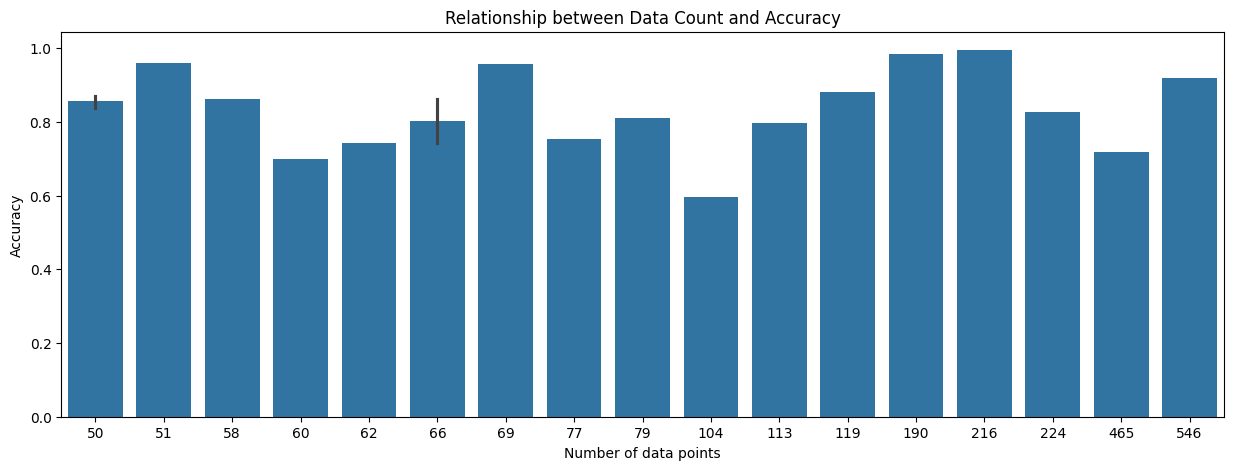

Correlation coefficient between data count and accuracy: -0.008784881622018893


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
# Calculate the number of data points for each category
category_data_counts = sample_data.groupby('task')['answer'].count().sort_values(ascending=False)

# Calculate the accuracy for each category
category_accuracies = {}
for category in classifying_tasks:
  category_data = sample_data[sample_data['task'] == category]
  correct_predictions = sum(category_data['predictions'] == category_data['answer'])
  total_predictions = len(category_data)
  accuracy = correct_predictions / total_predictions
  category_accuracies[category] = accuracy

# Create a DataFrame with the category, data count, and accuracy
results_df = pd.DataFrame({
    'category': category_data_counts.index,
    'data_count': category_data_counts.values,
    'accuracy': [category_accuracies[category] for category in category_data_counts.index]
})

# Sort the DataFrame by data count
results_df = results_df.sort_values(by='data_count', ascending=False)

# Plot the data count and accuracy for each category
plt.figure(figsize=(15, 5))
sns.barplot(x='data_count', y='accuracy', data=results_df)
plt.xlabel('Number of data points')
plt.ylabel('Accuracy')
plt.title('Relationship between Data Count and Accuracy')
plt.show()

# Calculate the correlation coefficient between data count and accuracy
correlation = results_df['data_count'].corr(results_df['accuracy'])
print(f"Correlation coefficient between data count and accuracy: {correlation}")

### Conclusions:

- Using TFIDF and GBD we got a test score of 0.71 which is still little overfitted from train score.
- The results maybe improved using a different vectorizer or tuning hyperparameters of the model.
- The category with the lowest accuracy was `consumer_contracts_qa`, with an accuracy of 0.57.
- Further analysis of the results for the `consumer_contracts_qa` category showed that the model was performing poorly on certain types of questions.
- Additional data and/or model tuning may be needed to improve the performance of the model on this category.